# Homework 2 - association rules

In this homework we will perform association between data series in the obesity dataset. For this notebook we will use the following formulas:

$$
\begin{align*}
    support(X) &= P(X) \\
            &= \frac{\text{number of instances containing X in the dataset}}{\text{total number of items in the dataset}} \\
    \\
    support(X \rightarrow Y) &= P(X \cap Y) \\
                            &= support(X \cup Y) \\
                            &= \frac{\text{number of instances containing both X and Y in the dataset}}{\text{total number of items in the dataset}} \\
    \\
    confidence(X \rightarrow Y) &= P(Y|X) = \frac{P(X \cap Y)}{P(X)} \\
                                &= \frac{support(X \cup Y)}{support(X)} \\
    \\
    lift(X \rightarrow Y) &= \frac{P(X \cap Y)}{P(X) \cdot P(Y)} \\
                          &= \frac{support(X \cup Y)}{support(X) \cdot support(Y)} \\
    \\
    conviction(X \rightarrow Y) &= \frac{1 - P(Y)}{1 - P(Y|X)} = \frac{1 - P(Y)}{1 - \frac{P(X \cap Y)}{P(X)}} \\
                                &= \frac{1 - support(Y)}{1 - confidence(X \rightarrow Y)} \\
\end{align*}
$$

We will use the Apriori and ECLAT algorithms.

## Conclusions

Using the Apriori algorithm, we gathered the following conclusions:
- for numerical - numerical attribute analysis:
  - With over average confidence (`0.67`) and low support (`0.27`), we can state that people that **consume many vegetables per day** also **consume more meals**
- for categorial - categorial attribute analysis:
  - Majority of the surveyed population **does not smoke** (support `0.97`, confidence `0.97`)
  - Majority of the surveyed population **does not perform calories monitoring** (support `0.95`, confidence `0.95`)
  - A good part of the surveyed population that **presents an overweight family member** reported **frequent consumption of high-caloric food** (support `0.74`, confidence `0.91`)
- for categorial + numerical - categorial + numerical attribute analysis:
  - With rather high confidence (`0.90`), but rather low support (`0.40`), people that **eat 3 meals per day**, **sometimes eat outside of meal hours** and **don't perform calorie monitoring** have **an overweight family member**

## Dependencies

### General dependencies

Imports for Python

### Dataset-specific dependencies

Dataset manager, known labels, known outputs for the dataset.

In [ ]:
import typing as t
import csv
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import arulespy.arules as arules
import arulespy.arulesViz as arulesviz
import rpy2.robjects.packages as packages
import rpy2.robjects.lib.ggplot2 as gp
from arulespy.arulesViz import plot, inspectDT
from IPython.display import HTML, IFrame
from rpy2.ipython.ggplot import image_png
htmlwidgets = packages.importr("htmlwidgets")


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
LABEL_VARIABLE = "NObeyesdad"
NUMERICAL_VARIABLES = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
CATEGORICAL_VARIABLES_NO_LABEL = [
    "FAVC",
    "CAEC",
    "CALC",
    "SCC",
    "MTRANS",
    "Gender",
    "family_history_with_overweight",
    "SMOKE",
]
CATEGORICAL_VARIABLES = [
    *CATEGORICAL_VARIABLES_NO_LABEL,
    LABEL_VARIABLE,
]
ALL_VARIABLES_NO_LABEL = [*NUMERICAL_VARIABLES, *CATEGORICAL_VARIABLES_NO_LABEL]
ALL_VARIABLES = [*NUMERICAL_VARIABLES, *CATEGORICAL_VARIABLES]
LABEL_DICTIONARY = {
    "Age": "Age",
    "Height": "Height (cm)",
    "Weight": "Weight (kg)",
    "FCVC": " Frequency of consumption of vegetables (times per day)",
    "NCP": "Number of main meals",
    "CH2O": "Consumption of water daily (Liters)",
    "FAF": "Physical activity frequency (times per day)",
    "TUE": "Time using technology devices (hours)",
    "FAVC": "Frequent consumption of high caloric food",
    "CAEC": "Consumption of food between meals",
    "CALC": "Consumption of alcohol",
    "SCC": "Calories consumption monitoring",
    "MTRANS": "Transportation used",
    "Gender": "Gender",
    "family_history_with_overweight": "Family member suffered or suffers from overweight",
    "SMOKE": "Smoker or not",
    "NObeyesdad": "Obesity level",
}

T = t.TypeVar("T")


class Person:
    Gender: str
    Age: np.int32
    Height: np.float32
    Weight: np.float32
    family_history_with_overweight: str
    FAVC: str
    FCVC: np.float32
    NCP: np.float32
    CAEC: str
    SMOKE: str
    CH2O: np.float32
    SCC: str
    FAF: np.float32
    TUE: np.float32
    CALC: str
    MTRANS: str
    NObeyesdad: str

    def __init__(
        self,
        Gender: str,
        Age: str,
        Height: str,
        Weight: str,
        family_history_with_overweight: str,
        FAVC: str,
        FCVC: str,
        NCP: str,
        CAEC: str,
        SMOKE: str,
        CH2O: str,
        SCC: str,
        FAF: str,
        TUE: str,
        CALC: str,
        MTRANS: str,
        NObeyesdad: str,
    ):
        self.Gender = Gender
        self.Age = np.float32(Age)
        self.Height = np.float32(Height)
        self.Weight = np.float32(Weight)
        self.family_history_with_overweight = family_history_with_overweight
        self.FAVC = FAVC
        self.FCVC = np.float32(FCVC)
        self.NCP = np.float32(NCP)
        self.CAEC = CAEC
        self.SMOKE = SMOKE
        self.CH2O = np.float32(CH2O)
        self.SCC = SCC
        self.FAF = np.float32(FAF)
        self.TUE = np.float32(TUE)
        self.CALC = CALC
        self.MTRANS = MTRANS
        self.NObeyesdad = NObeyesdad

    def __str__(self):
        return vars(self)

    def __len__(self):
        return len(vars(self))

    def __repr__(self):
        return vars(self)


class DatasetManager:
    def __init__(self, path_to_csv: str):
        self.path_to_csv = path_to_csv

    def load_as_obj_list(self) -> list[Person]:
        with open(self.path_to_csv) as csv_file:
            csv_reader = csv.DictReader(csv_file)
            return [Person(**row) for row in csv_reader]

In [ ]:
dataset_manager = DatasetManager("data/ObesityDataSet.csv")
dataset_obj_list = dataset_manager.load_as_obj_list()
dataset_dataframe = pd.DataFrame.from_records(
    data=[vars(entry) for entry in dataset_obj_list]
)

### Categorial data utility functions

Here we add utility functions (if any) for the categorial data types.

In [ ]:
# TODO: add if any are found

### Continuous data utility functions

Here we add utility functions (if any) for the continuous data types.

In [ ]:
def bin_numerical_equally_by_frequency(
    data: t.Union[npt.NDArray[np.float32], npt.NDArray[np.int32]], bins: int = 30
):
    """
    Performs roughly equal binning based on the frequency of the items.
    Example: For data = [1, 2, 3, 4, 5, 6, 7, 8, 9] and bins = 3, result will be (1, 3], (3, 6], (6, 9]
    """

    if type(data[0]) is not np.float32 and type(data[0]) is not np.int32:
        return data

    result = pd.qcut(data, q=bins, duplicates="drop")
    return result

### Algorithm utility functions

Here we add utility functions for the algorithms to help us reduce code duplication.

In [ ]:
def run_apriori(
    transactions: arules.ro.DataFrame, support: float, confidence: float
) -> t.Optional[pd.DataFrame]:
    try:
        rules = arules.apriori(
            transactions,
            parameter=arules.parameters({"supp": support, "conf": confidence}),
            control=arules.parameters({"verbose": False}),
        )
        return rules.as_df()
    except:
        return None


def run_apriori_build_html(
    transactions: arules.ro.DataFrame, support: float, confidence: float
) -> str:
    result = ""

    rules_dataframe = run_apriori(
        transactions=transactions, support=support, confidence=confidence
    )

    result += f"<h2>Result for Apriori run (support: {support}, confidence: {confidence})</h2>"
    result += (
        rules_dataframe.to_html()
        if rules_dataframe is not None
        else "<p>No rules were found</p>"
    )
    result += "</br>"

    return result


def run_eclat(
    transactions: arules.ro.DataFrame, support: float, confidence: float
) -> t.Optional[pd.DataFrame]:
    try:
        rules = arules.eclat(
            transactions,
            parameter=arules.parameters({"supp": support}),
            control=arules.parameters({"verbose": False}),
        )
        return rules.as_df()
    except:
        return None


def run_eclat_build_html(
    transactions: arules.ro.DataFrame, support: float, confidence: float
) -> str:
    result = ""

    rules_dataframe = run_eclat(
        transactions=transactions, support=support, confidence=confidence
    )

    result += f"<h2>Result for ECLAT run (support: {support})</h2>"
    result += (
        rules_dataframe.to_html()
        if rules_dataframe is not None
        else "<p>No rules were found</p>"
    )
    result += "</br>"

    return result

## Preliminary data analysis

Here we built plots for the data. Mostly for debugging purposes.

In [ ]:
for label in CATEGORICAL_VARIABLES_NO_LABEL:
    pretty_label = LABEL_DICTIONARY[label]
    dataset_subset_dataframe = dataset_dataframe[label].astype(str)

    plt.figure()
    plt.hist(dataset_subset_dataframe)
    plt.xlabel(pretty_label)
    plt.ylabel("Count")
    plt.show()

In [ ]:
for label in NUMERICAL_VARIABLES:
    pretty_label = LABEL_DICTIONARY[label]
    dataset_subset_dataframe = dataset_dataframe[label].astype(np.float32)
    binned_data = bin_numerical_equally_by_frequency(
        data=dataset_subset_dataframe, bins=10
    )

    plt.figure()
    binned_data.value_counts().plot(kind="bar", xlabel=label, ylabel="Count", rot=90)
    plt.xlabel(pretty_label)
    plt.ylabel("Count")
    plt.show()

## Finding association rules

Here we use the `arules` library to find association rules.

### Categorical - categorical associations with Apriori algorithm

In [ ]:
parameters = [
    (0.5, 0.90),
    (0.7, 0.4),
    (0.8, 0.8),
    (0.9, 0.8),
    (0.9, 0.9),
    (0.95, 0.9),
    (0.95, 0.95),
]

dataset_subset_dataframe = dataset_dataframe[CATEGORICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)
result = ""

for support, confidence in parameters:
    result += run_apriori_build_html(
        transactions=transactions, support=support, confidence=confidence
    )

HTML(result)

### Categorial - categorial associations with ECLAT algorithm

In [ ]:
parameters = [
    (0.7, 0.4),
    (0.8, 0.8),
    (0.9, 0.8),
    (0.9, 0.9),
    (0.95, 0.9),
    (0.95, 0.95),
]

dataset_subset_dataframe = dataset_dataframe[CATEGORICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

for support, confidence in parameters:
    result += run_eclat_build_html(
        transactions=transactions, support=support, confidence=confidence
    )

HTML(result)

### Numerical - numerical associations with Apriori algorithm

In [ ]:
parameters = [
    (0.1, 0.1),
    (0.2, 0.5),
]

dataset_subset_dataframe = dataset_dataframe[NUMERICAL_VARIABLES]
dataset_subset_dataframe = dataset_subset_dataframe.apply(
    lambda dataseries: bin_numerical_equally_by_frequency(data=dataseries, bins=10)
)
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

for support, confidence in parameters:
    result += run_apriori_build_html(
        transactions=transactions, support=support, confidence=confidence
    )

HTML(result)

### Numerical - numerical associations with ECLAT algorithm

In [ ]:
parameters = [
    (0.1, 0.1),
    (0.2, 0.5),
]

dataset_subset_dataframe = dataset_dataframe[NUMERICAL_VARIABLES]
dataset_subset_dataframe = dataset_subset_dataframe.apply(
    lambda dataseries: bin_numerical_equally_by_frequency(data=dataseries, bins=10)
)
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

for support, confidence in parameters:
    result += run_eclat_build_html(
        transactions=transactions, support=support, confidence=confidence
    )

HTML(result)

### Categorical + numerical - categorical + numerical associations with Apriori algorithm

In [ ]:
parameters = [
    (0.4, 0.9),
]

dataset_subset_dataframe = dataset_dataframe[ALL_VARIABLES]
dataset_subset_dataframe = dataset_subset_dataframe.apply(
    lambda dataseries: bin_numerical_equally_by_frequency(data=dataseries, bins=10)
)
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

for support, confidence in parameters:
    result += run_apriori_build_html(
        transactions=transactions, support=support, confidence=confidence
    )

HTML(result)

### Categorical + numerical - categorical + numerical associations with ECLAT algorithm

In [ ]:
parameters = [
    (0.4, 0.9),
]

dataset_subset_dataframe = dataset_dataframe[ALL_VARIABLES]
dataset_subset_dataframe = dataset_subset_dataframe.apply(
    lambda dataseries: bin_numerical_equally_by_frequency(data=dataseries, bins=10)
)
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

for support, confidence in parameters:
    result += run_eclat_build_html(
        transactions=transactions, support=support, confidence=confidence
    )

HTML(result)

## Visualisations

Here we visualise the rules we found using the algorithms above.

### Categorical - categorical visualisations

In [ ]:
dataset_subset_dataframe = dataset_dataframe[CATEGORICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.5, "conf": 0.90}),
    control=arules.parameters({"verbose": False}),
)

gg = plot(rules, method="scatter")
image_png(gg)

In [ ]:
dataset_subset_dataframe = dataset_dataframe[CATEGORICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.5, "conf": 0.90}),
    control=arules.parameters({"verbose": False}),
)

gg = plot(rules, method="grouped")
image_png(gg)

In [ ]:
dataset_subset_dataframe = dataset_dataframe[CATEGORICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.5, "conf": 0.90}),
    control=arules.parameters({"verbose": False}),
)

rules_20 = rules.sort(by = 'confidence')[0:100]
gg = plot(rules_20, method="graph")
image_png(gg)

### Numerical - numerical visualisations

In [ ]:
dataset_subset_dataframe = dataset_dataframe[NUMERICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.2, "conf": 0.4}),
    control=arules.parameters({"verbose": False}),
)

gg = plot(rules, method="scatter")
image_png(gg)

In [ ]:
dataset_subset_dataframe = dataset_dataframe[NUMERICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.2, "conf": 0.4}),
    control=arules.parameters({"verbose": False}),
)

gg = plot(rules, method="grouped")
image_png(gg)

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Column(s) 1, 2, 3, 4, 5, 6, 7, 8 not logical or factor. Applying default discretization (see '? discretizeDF'). 

R[write to console]: 2: 
R[write to console]: In discretize(x = c(3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,  :
R[write to console]: 
 
R[write to console]:  The calculated breaks are: 1, 3, 3, 4
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.



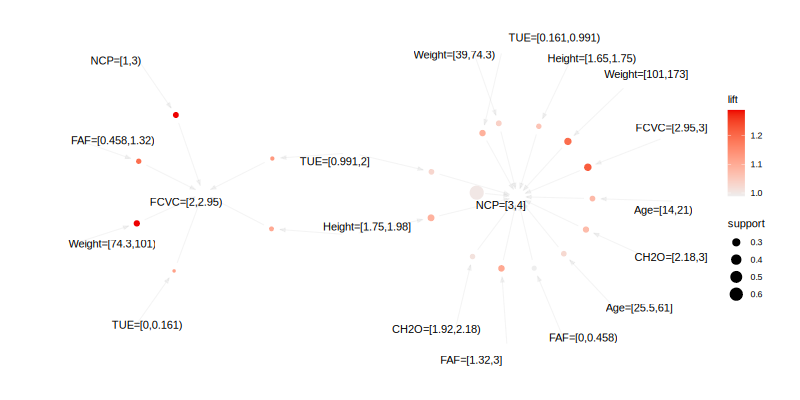

In [35]:
dataset_subset_dataframe = dataset_dataframe[NUMERICAL_VARIABLES]
transactions = arules.Transactions.from_df(dataset_subset_dataframe)

rules = arules.apriori(
    transactions,
    parameter=arules.parameters({"supp": 0.2, "conf": 0.2}),
    control=arules.parameters({"verbose": False}),
)

rules_20 = rules.sort(by = 'confidence')[0:20]
gg = plot(rules_20, method="graph")
image_png(gg)